# 신규 아파트 주차 수요 예측

<img src = "https://github.com/Jangrae/img/blob/master/parking.png?raw=true" width=800, align="left"/>

# 단계 1: 데이터 전처리

## [미션]

단지별 등록 차량 수를 예측하기에 적합한 형태로 데이터 전처리를 수행합니다.

1) 필요한 변수를 추가하고 불필요한 변수를 제거합니다.
2) 단지별 데이터와 상세 데이터를 분리합니다.
3) 상세 데이터를 단지별로 집계합니다.
    - 단지별 총면적 집계
    - 전용면적구간 집계 (피벗형태)
    - 단지별 임대보증금, 임대료 평균 집계
4) 단지별 데이터와 집계 데이터를 하나로 합칩니다.
5) 변수 추가 (옵션)
    - 등록 차량수를 예측하기 위해 필요한 변수를 추가합니다.

## 1. 환경설정

### (1) 로컬 수행(Anaconda)

- project 폴더에 필요한 파일들을 넣고, 본 파일을 열었다면, 별도 경로 지정이 필요하지 않습니다.

In [20]:
# 기본 경로
path = ''

### (2) 구글 콜랩 수행

- 구글 콜랩을 사용중이면 구글 드라이브를 연결합니다.

In [23]:
# 구글 드라이브 연결, 패스 지정
import sys
if 'google.colab' in sys.modules:
    from google.colab import drive
    drive.mount('/content/drive')
    path = '/content/drive/MyDrive/project/'

### (3) 한글 폰트 표시용 라이브러리 설치

In [223]:
# 한글 표시를 위한 라이브러리 설치
# !pip install koreanize_matplotlib -q

### (4) 라이브러리 불러오기

In [25]:
# 라이브러리 불러오기
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import koreanize_matplotlib
import seaborn as sns

import joblib
import warnings

warnings.filterwarnings(action='ignore')
%config InlineBackend.figure_format='retina'

### (5) 데이터 불러오기

- 학습용 데이터(train.xlsx)를 읽어옵니다.
- 읽어온 데이터를 apart 데이터프레임으로 선언합니다.
- 평가용 데이터(test.xlsx) 파일은 모델 완성 후 사용할 미래의 데이터입니다.

#### 1) 데이터 불러오기

In [29]:
# 파일 불러오기
apart = pd.read_excel(path+'train.xlsx')

In [30]:
pd.set_option('display.max_rows', 100)

#### 2) 기본 정보 조회

In [32]:
apart.describe()

,총세대수,전용면적별세대수,준공일자,단지내주차면수,전용면적,공용면적,임대보증금,임대료,실차량수
count,1157.000000,1157.000000,1.157000e+03,1157.000000,1157.000000,1157.000000,1.157000e+03,1.157000e+03,1157.000000
mean,659.075194,163.691443,2.008667e+07,682.261884,51.565584,20.562360,2.850789e+07,2.259409e+05,650.762316
std,456.110643,166.766358,6.777985e+04,473.331805,18.243315,5.164405,2.890687e+07,1.768102e+05,390.573462
min,1.000000,1.000000,1.992010e+07,10.000000,17.590000,5.850000,0.000000e+00,0.000000e+00,21.000000
25%,315.000000,44.000000,2.005031e+07,308.000000,39.480000,16.997400,1.379700e+07,1.177400e+05,320.000000
50%,595.000000,112.000000,2.010042e+07,629.000000,46.900000,20.384700,1.997300e+07,1.842900e+05,626.000000
75%,918.000000,229.000000,2.013121e+07,911.000000,59.810000,23.722500,3.375300e+07,2.634400e+05,894.000000
max,2289.000000,1258.000000,2.022071e+07,4553.000000,139.350000,42.760000,2.549220e+08,1.058030e+06,1657.000000


#### 3) 결측치 분석 및 대체 방향
- 방향성
1. 각 피처의 최빈값으로 일괄 대체 (기각)

2. 각 연도의 기술 발전 및 트렌드를 기반으로, 연도별 각 피처의 최빈값으로 대체 (채택)

3. 승강기 설치 여부 데이터에 한하여 KNN 알고리즘을 기반으로 결측치 값 예측 (보류)

4. 결측치 제거 전, 난방방식/승강기 설치 여부에 대해 미리 범주 재분류 작업 수행 -> 데이터의 일관성 및 안정성 확보 (채택)

5. 2022년도의 난방방식 결측치는 2021년도의 기술과 트렌드가 유사할 것으로 보아, 2021년도 최빈값으로 설정 (기각) -> 외부데이터(실제 아파트) 기반 결측치 보완(채택)

6. 총세대수 또는 총면적이 작은 경우 승강기 미설치 빈도가 상대적으로 높음. 하지만 승강기 설치 빈도가 훨씬 높음 (기각)

7. 임대료 또는 임대보증금의 값이 0인 데이터는 결측치 인가??? -> 필요한 데이터 인가? 지원 제도 조사 필요 (보류)

0원인 이유
8. 임대료 대신해서 다른 조건을 충족하면 임대료 감소 또는 면제
9. 정책적으로 명시 x
10. 제도 ex) 자녀수에 따라 임대료 감소
조건을 충족하여 혜택을 받을 경우에는 차량이 없을 확률이 높다.

#### (1) 데이터 추가 및 재분류
- 준공연도 추가
- 총면적 추가
- 난방 방식 재분류
- 승강기 설치 여부 재분류

In [38]:
# 분석에 필요한 데이터 추가
apart['준공연도']=apart['준공일자'] //10000
apart['총면적']=(apart['전용면적']+apart['공용면적'])*apart['전용면적별세대수']
#범주 재분류
apart['난방방식'] = apart['난방방식'].str[:2]
apart['승강기설치여부'] = apart['승강기설치여부'].replace({
    '전체동 설치': '1',
    '일부동 설치': '0',
    '미설치': '0',
})

#### (2) 연도별 난방 방식 빈도 시각화 및 연도별 최빈값 추출

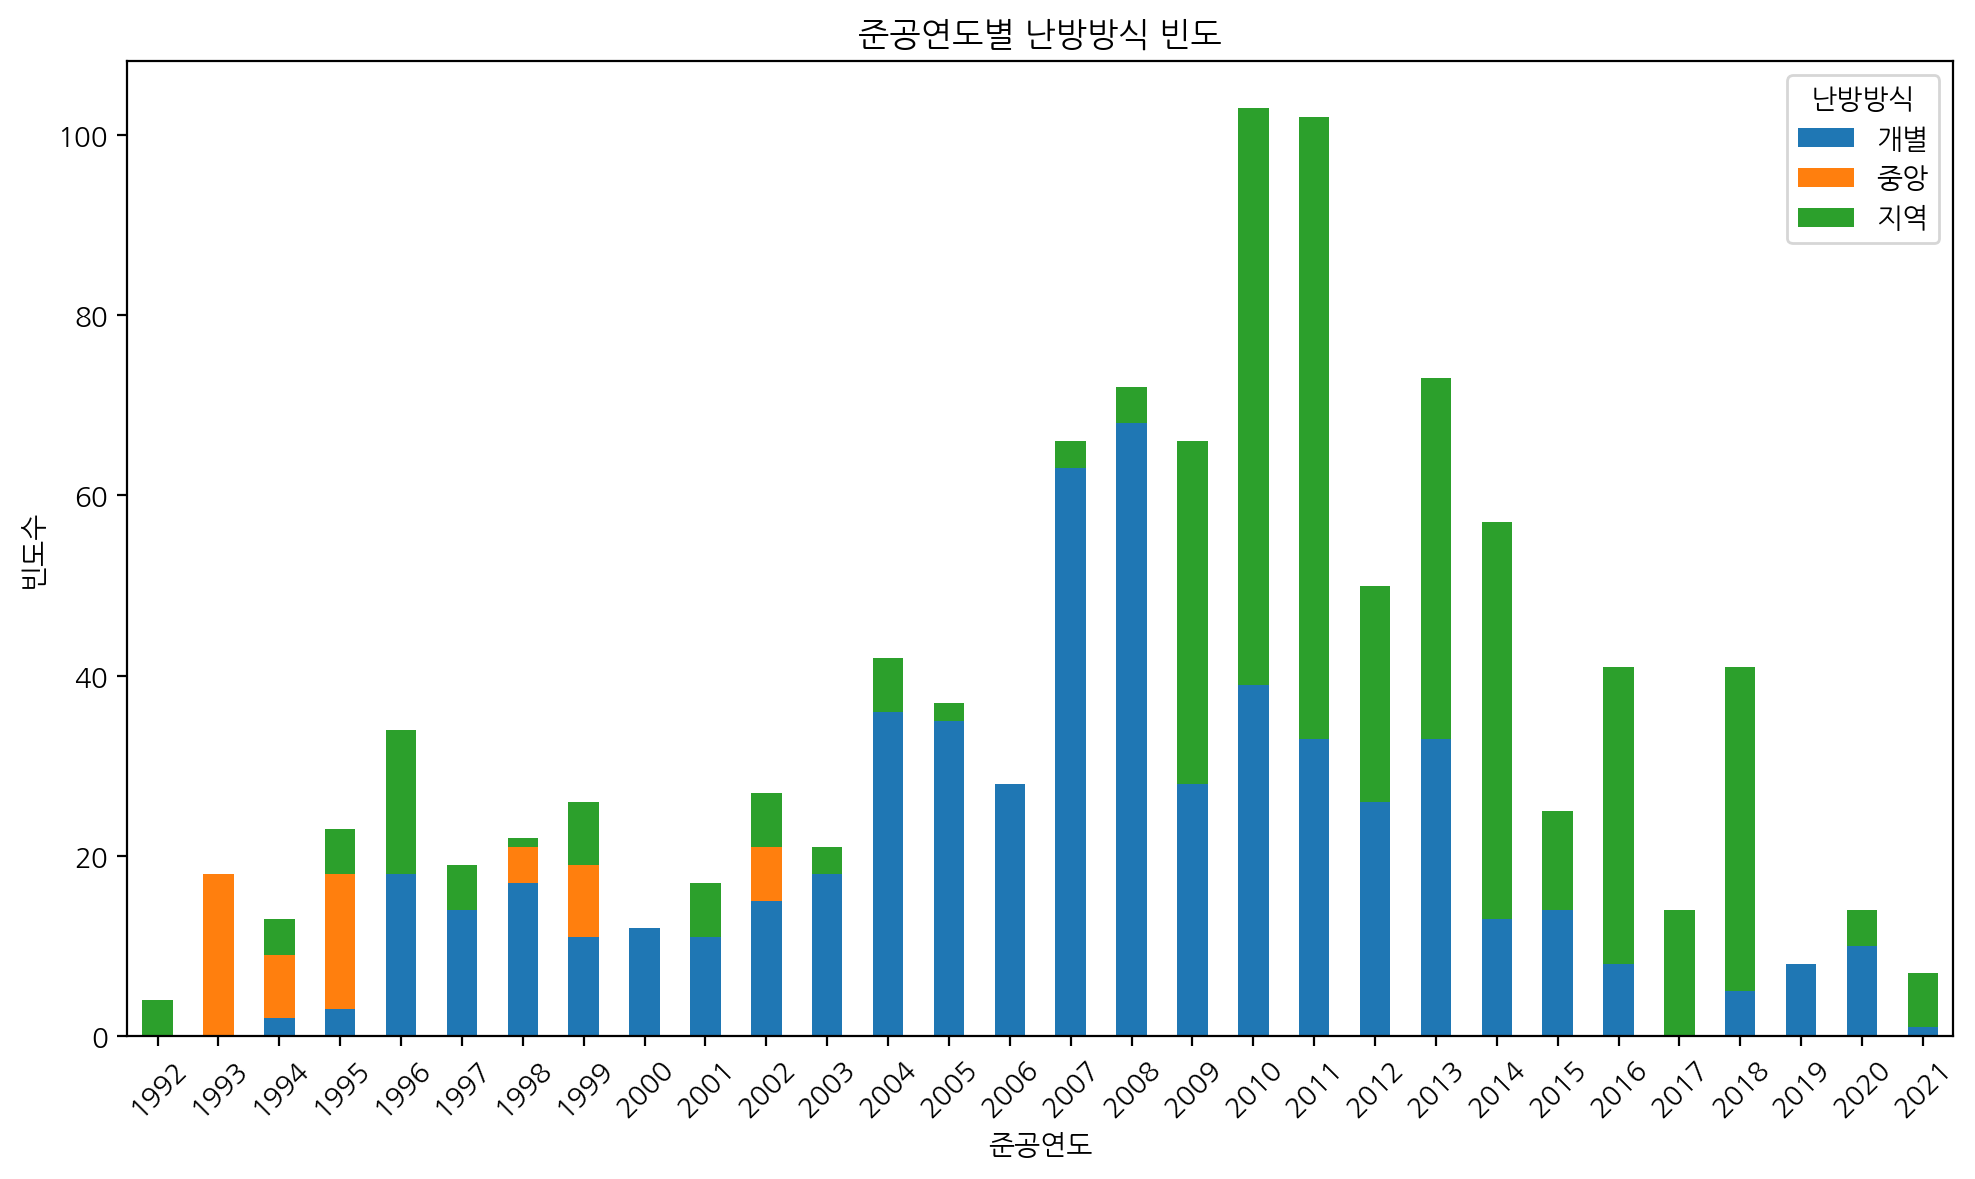

{1992: '지역', 1993: '중앙', 1994: '중앙', 1995: '중앙', 1996: '개별', 1997: '개별', 1998: '개별', 1999: '개별', 2000: '개별', 2001: '개별', 2002: '개별', 2003: '개별', 2004: '개별', 2005: '개별', 2006: '개별', 2007: '개별', 2008: '개별', 2009: '지역', 2010: '지역', 2011: '지역', 2012: '개별', 2013: '지역', 2014: '지역', 2015: '개별', 2016: '지역', 2017: '지역', 2018: '지역', 2019: '개별', 2020: '개별', 2021: '지역'}


In [41]:
# 연도별 난방 방식 빈도 시각화
grouped_year_heating = apart.groupby('준공연도')['난방방식'].value_counts()
grouped_year_heating.unstack().plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('준공연도별 난방방식 빈도')
plt.ylabel('빈도수')
plt.xlabel('준공연도')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
# 연도별 최빈값 추출
pivot_df = apart.pivot_table(index='준공연도', columns='난방방식', aggfunc='size', fill_value=0)
max_heating_by_year = pivot_df.idxmax(axis=1).to_dict()
print(max_heating_by_year)

#### (3) 연도별 건물형태 빈도 시각화 및 연도별 최빈값 추출

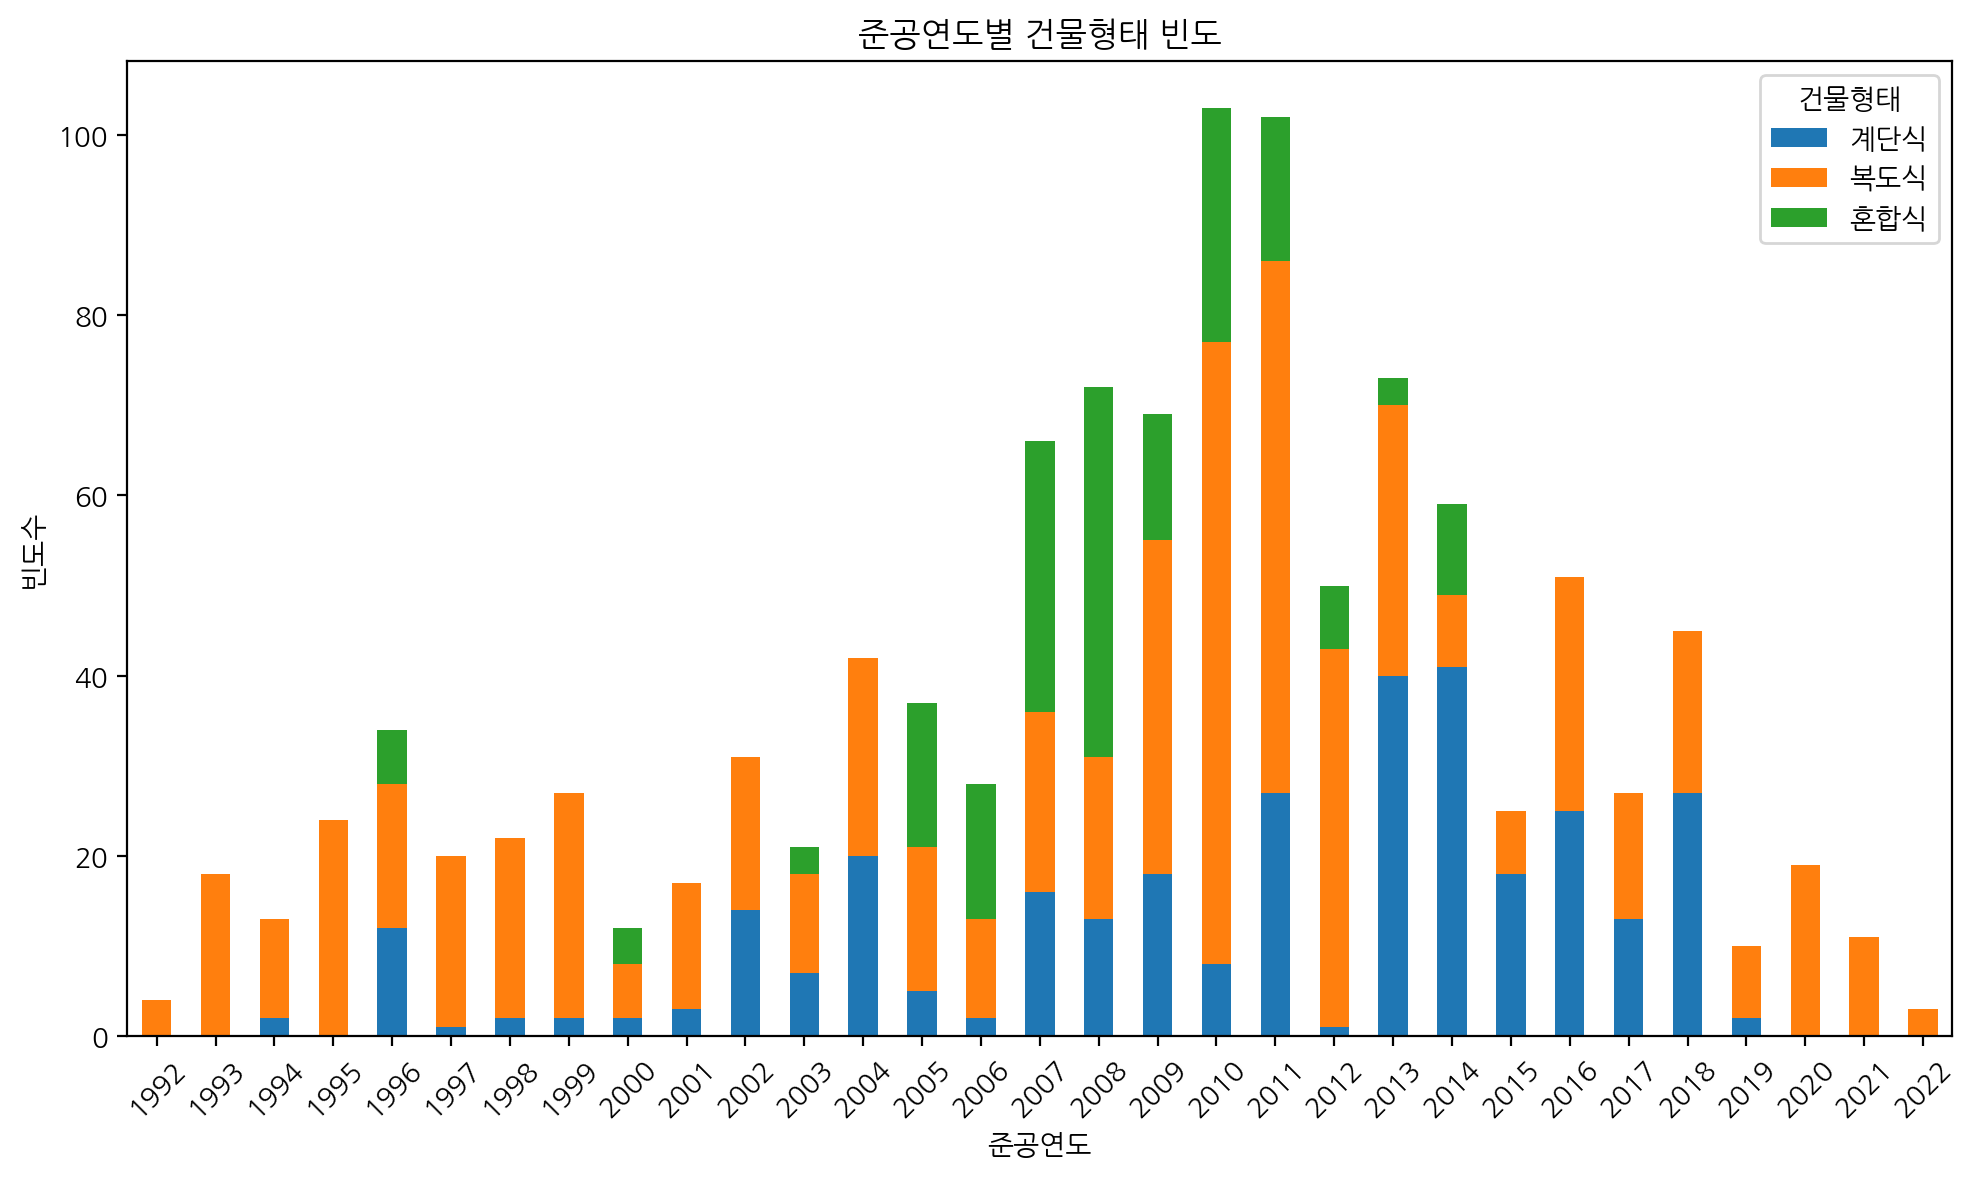

{1992: '복도식', 1993: '복도식', 1994: '복도식', 1995: '복도식', 1996: '복도식', 1997: '복도식', 1998: '복도식', 1999: '복도식', 2000: '복도식', 2001: '복도식', 2002: '복도식', 2003: '복도식', 2004: '복도식', 2005: '복도식', 2006: '혼합식', 2007: '혼합식', 2008: '혼합식', 2009: '복도식', 2010: '복도식', 2011: '복도식', 2012: '복도식', 2013: '계단식', 2014: '계단식', 2015: '계단식', 2016: '복도식', 2017: '복도식', 2018: '계단식', 2019: '복도식', 2020: '복도식', 2021: '복도식', 2022: '복도식'}


In [43]:
# 연도별 건물형태 빈도 시각화
grouped_year_building = apart.groupby('준공연도')['건물형태'].value_counts()
grouped_year_building.unstack().plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('준공연도별 건물형태 빈도')
plt.ylabel('빈도수')
plt.xlabel('준공연도')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
# 연도별 최빈값 추출
pivot_df = apart.pivot_table(index='준공연도', columns='건물형태', aggfunc='size', fill_value=0)
max_building_by_year = pivot_df.idxmax(axis=1).to_dict()
print(max_building_by_year)

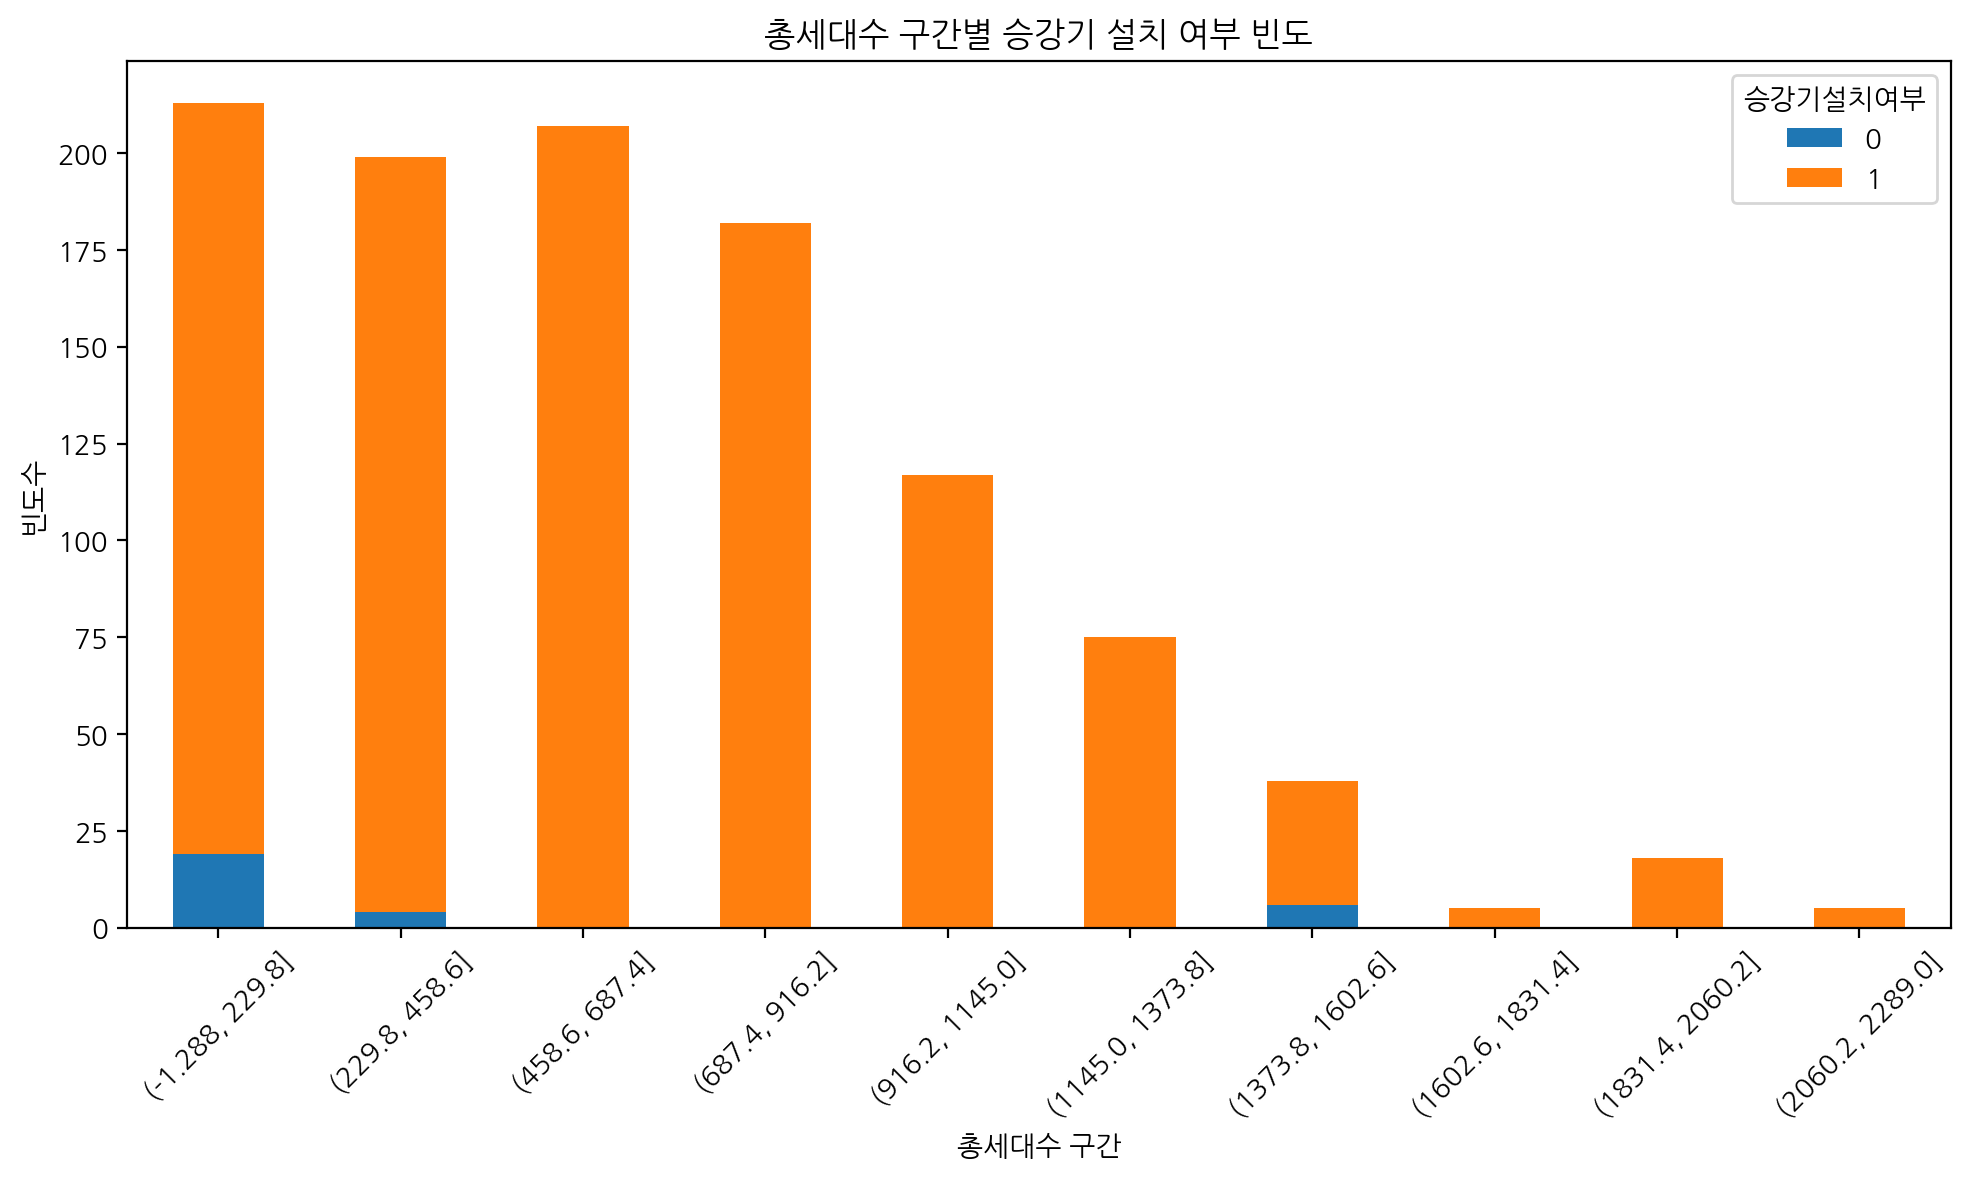

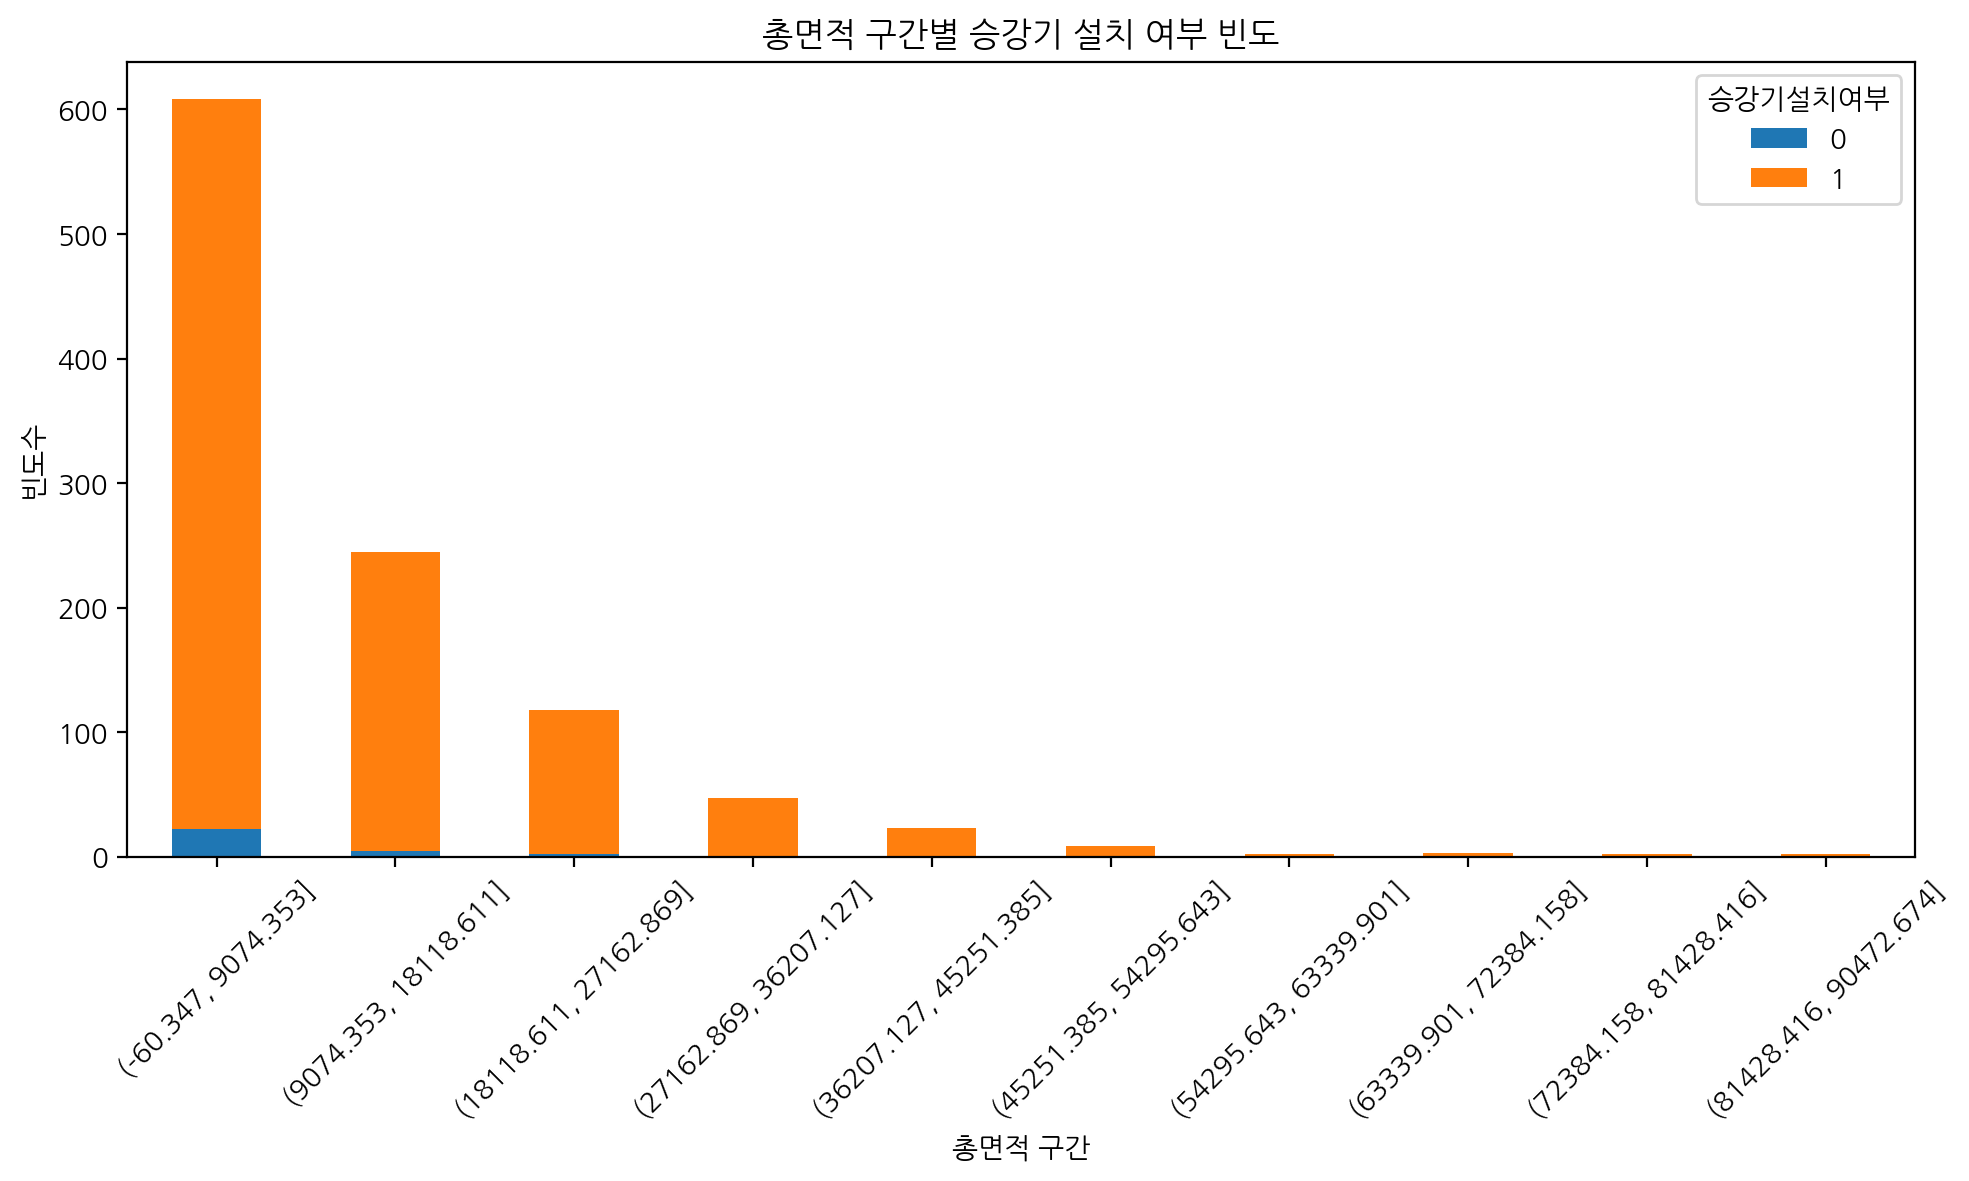

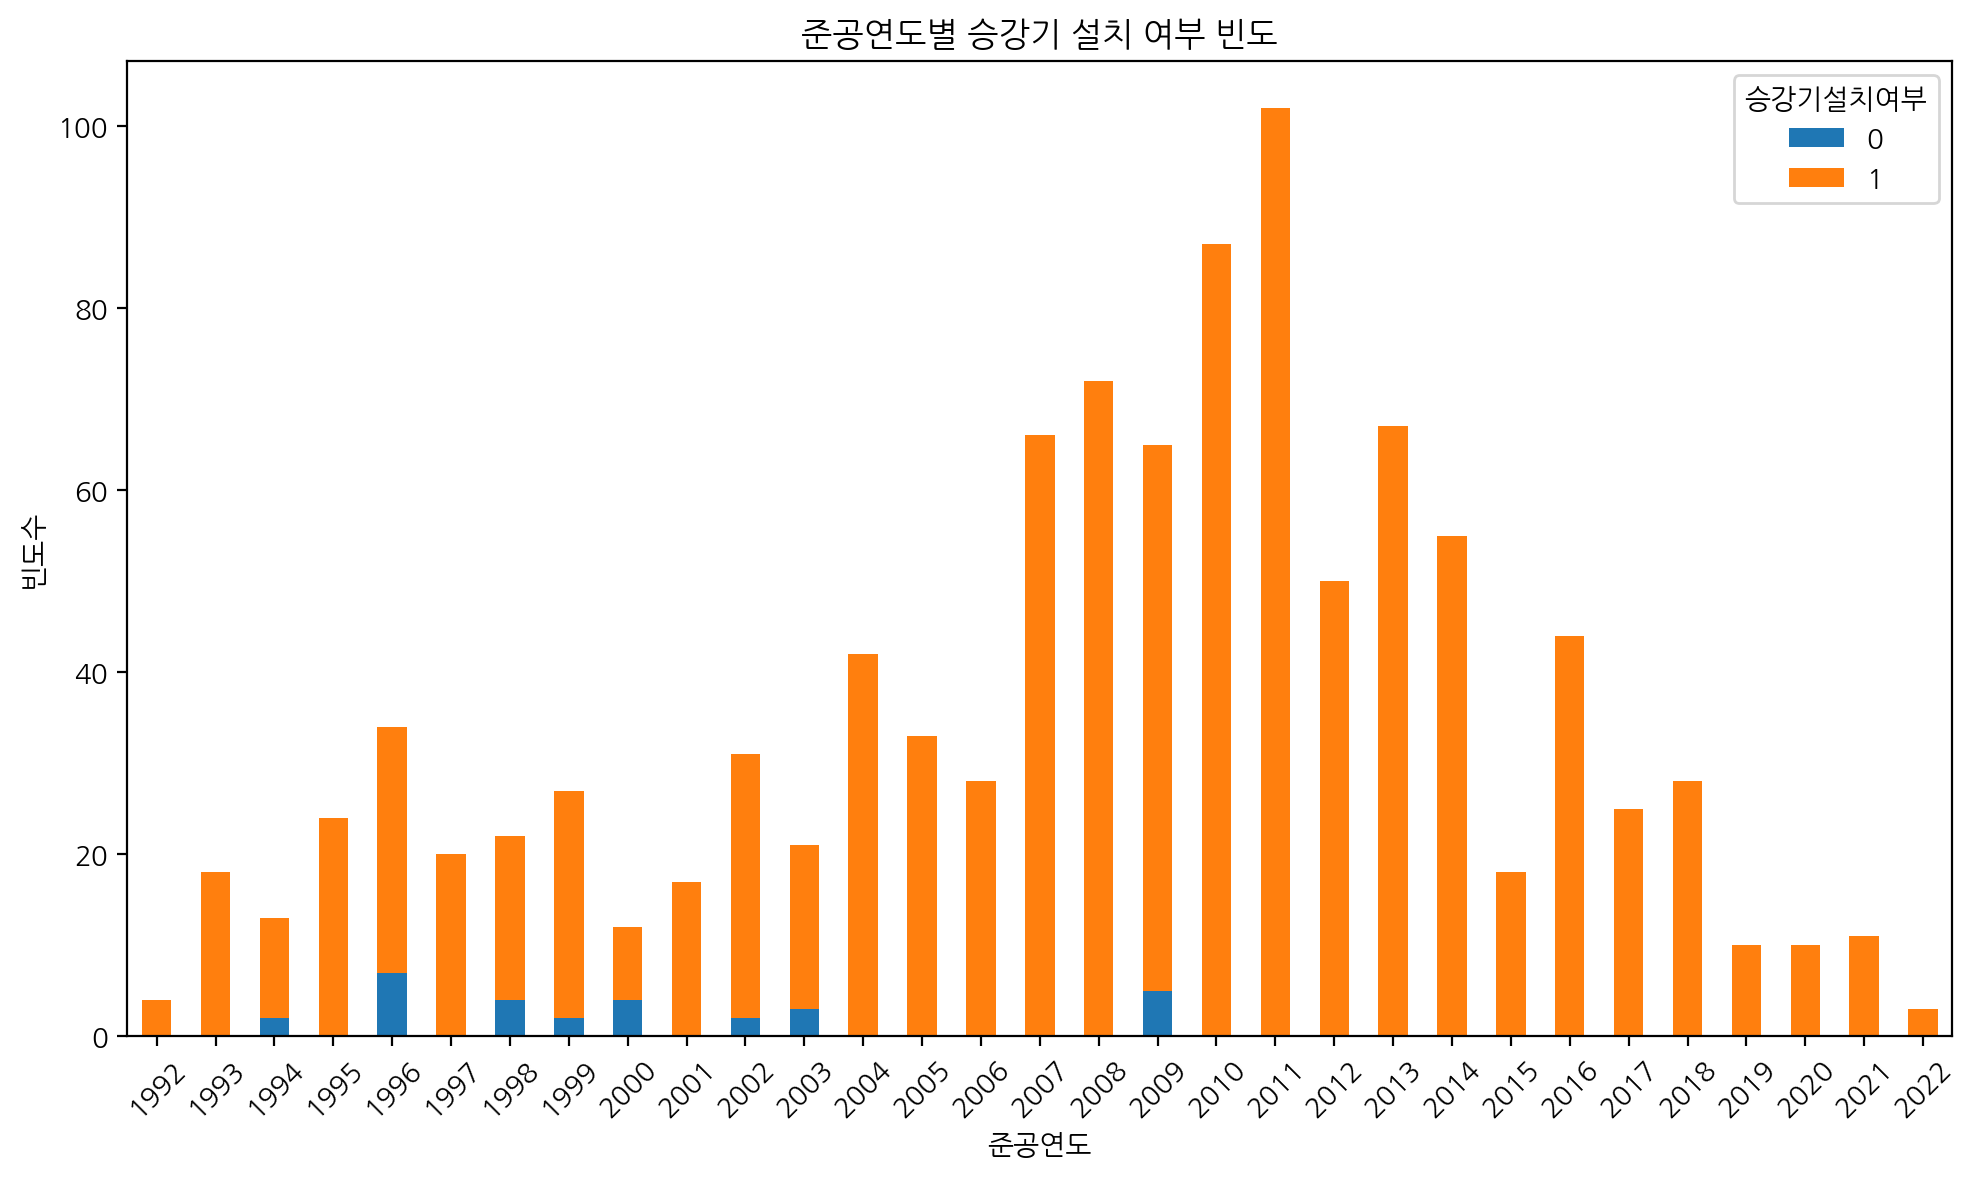

{1992: '1', 1993: '1', 1994: '1', 1995: '1', 1996: '1', 1997: '1', 1998: '1', 1999: '1', 2000: '1', 2001: '1', 2002: '1', 2003: '1', 2004: '1', 2005: '1', 2006: '1', 2007: '1', 2008: '1', 2009: '1', 2010: '1', 2011: '1', 2012: '1', 2013: '1', 2014: '1', 2015: '1', 2016: '1', 2017: '1', 2018: '1', 2019: '1', 2020: '1', 2021: '1', 2022: '1'}


In [44]:
# 총세대수 및 총면적을 10개의 구간으로 분리
apart['총세대수_구간'] = pd.cut(apart['총세대수'], bins=10)
apart['총면적_구간'] = pd.cut(apart['총면적'], bins=10)
# 총세대수 및 총면적 구간별 건물형태 빈도 시각화
grouped_se_elevator = apart.groupby('총세대수_구간')['승강기설치여부'].value_counts()
grouped_area_elevator = apart.groupby('총면적_구간')['승강기설치여부'].value_counts()
grouped_se_elevator.unstack().plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('총세대수 구간별 승강기 설치 여부 빈도')
plt.ylabel('빈도수')
plt.xlabel('총세대수 구간')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
grouped_area_elevator.unstack().plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('총면적 구간별 승강기 설치 여부 빈도')
plt.ylabel('빈도수')
plt.xlabel('총면적 구간')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
# 연도별 건물형태 빈도 시각화
grouped_year_elevator = apart.groupby('준공연도')['승강기설치여부'].value_counts()
grouped_year_elevator.unstack().plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('준공연도별 승강기 설치 여부 빈도')
plt.ylabel('빈도수')
plt.xlabel('준공연도')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
# 연도별 최빈값 추출
pivot_df = apart.pivot_table(index='준공연도', columns='승강기설치여부', aggfunc='size', fill_value=0)
max_ele_by_year = pivot_df.idxmax(axis=1).to_dict()
print(max_ele_by_year)

In [58]:


max_heating_by_year

{1992: '지역',
 1993: '중앙',
 1994: '중앙',
 1995: '중앙',
 1996: '개별',
 1997: '개별',
 1998: '개별',
 1999: '개별',
 2000: '개별',
 2001: '개별',
 2002: '개별',
 2003: '개별',
 2004: '개별',
 2005: '개별',
 2006: '개별',
 2007: '개별',
 2008: '개별',
 2009: '지역',
 2010: '지역',
 2011: '지역',
 2012: '개별',
 2013: '지역',
 2014: '지역',
 2015: '개별',
 2016: '지역',
 2017: '지역',
 2018: '지역',
 2019: '개별',
 2020: '개별',
 2021: '지역'}

## 2. 데이터 전처리 ①

- 결측치 존재 여부를 확인하고 적절히 처리합니다.
- 필요한 변수를 추가하고, 불필요한 변수를 제거합니다.

### (1) 결측치 처리

- 결측치가 있는 지 확인합니다.

In [17]:
apart.isna().sum()

NameError: name 'apart' is not defined

- 결측치는 적절한 값으로 채웁니다.
- 예를 들어 범주형 변수인 경우는 각 변수의 최빈값으로 채울 수 있습니다.

# 결측치 처리
1. 최빈값(시키는대로)
2. 연도별 최빈값(난방,건설형태)  -> 채택
3. KNN을 통한 결측치 처리 (승강기설치여부)  -> 채택

# 고려사항: 난방/엘베 데이터는 대체 후 결측치 처리

In [245]:
# 연도별 최빈값으로 대체
for year, heating_type in max_heating_by_year.items():
    apart.loc[(apart['준공연도'] == year) & (apart['난방방식'].isna()), '난방방식'] = heating_type
for year, building_type in max_building_by_year.items():
    apart.loc[(apart['준공연도'] == year) & (apart['건물형태'].isna()), '건물형태'] = building_type
for year, ele_type in max_ele_by_year.items():
    apart.loc[(apart['준공연도'] == year) & (apart['승강기설치여부'].isna()), '승강기설치여부'] = ele_type
# 외부 데이터 기반  결측치 보완
apart.loc[apart['준공연도']==2022,'난방방식']='개별'

In [246]:
apart.isna().sum()

단지코드        0
단지명         0
총세대수        0
전용면적별세대수    0
지역          0
준공일자        0
건물형태        0
난방방식        0
승강기설치여부     0
단지내주차면수     0
전용면적        0
공용면적        0
임대보증금       0
임대료         0
실차량수        0
준공연도        0
총면적         0
총세대수_구간     0
총면적_구간      0
dtype: int64

### (2) 변수 추가

- '준공일자' 변수 값 앞 4 자리를 갖는 int 형 변수 '준공연도'를 추가합니다.
- 총면적 = (전용면적 + 공용면적) * 전용면적별세대수 공식에 따른'총면적' 변수를 추가합니다.

In [248]:
# 사전에 작업 수행

# apart['준공연도']=apart['준공일자'] //10000
# apart['총면적']=(apart['전용면적']+apart['공용면적'])*apart['전용면적별세대수']

### (3) 불필요한 변수 제거

- '단지명' 변수는 단일값을 가지므로 제거합니다.
- '단지내주차면수' 변숫값을 기반으로 등록 차량수를 예측하는 것은 의미가 없으니, '단지내주차면수' 변수를 제거합니다.
- '준공연도' 변수를 추가했으니 '준공일자' 변수를 제거합니다.

In [250]:
# 불필요한 데이터 제거 (분석을 위해 추가했던 피처 또한 제거)
apart=apart.drop(['단지명','단지내주차면수','준공일자','총세대수_구간','총면적_구간'],axis=1)

## 3. 데이터 전처리 ②

- 단지별 데이터와 상세 데이터로 분리합니다.
- 상세 데이터를 3가지 형태로 집계합니다.
- 단지별 데이터와 상세 데이터 집계 결과를 조인(Merge) 합니다.

### (1) 데이터 분리

- 단지별 데이터를 갖는 data01 데이터프레임을 선언합니다.
- 상세 데이터를 갖는 data02 데이터프레임을 선언합니다.

#### 1) 단지별 데이터 분리

- 다음 열을 갖는 data01 데이터프레임으로 선언합니다.
    - '단지코드', '총세대수', '지역', '준공연도', '건물형태', '난방방식', '승강기설치여부', '실차량수'
- data01 데이터프레임의 중복행을 제거합니다.
- 인덱스를 초기화 합니다. (단, 기존 인덱스 제거)
- 중복행 제거 여부를 필히 확인합니다.

In [254]:
apart

,단지코드,총세대수,전용면적별세대수,지역,건물형태,난방방식,승강기설치여부,전용면적,공용면적,임대보증금,임대료,실차량수,준공연도,총면적
0,C0001,78,35,서울,계단식,개별,1,51.89,19.2603,50758000,620370,109,2013,2490.2605
1,C0001,78,43,서울,계단식,개별,1,59.93,22.2446,63166000,665490,109,2013,3533.5078
2,C0002,35,26,서울,복도식,개별,1,27.75,16.5375,63062000,458640,35,2013,1151.4750
3,C0002,35,9,서울,복도식,개별,1,29.08,17.3302,63062000,481560,35,2013,417.6918
4,C0003,88,7,서울,계단식,개별,1,59.47,21.9462,72190000,586540,88,2013,569.9134
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1152,C0356,956,956,경기,복도식,지역,1,26.37,12.7500,9931000,134540,243,1994,37398.7200
1153,C0358,120,66,강원,복도식,개별,1,24.83,15.1557,2129000,42350,47,2020,2639.0562
1154,C0358,120,54,강원,복도식,개별,1,33.84,20.6553,2902000,57730,47,2020,2942.7462
1155,C0359,447,149,대구경북,복도식,중앙,1,26.37,13.3800,7134000,118880,78,1994,5922.7500


In [255]:
data01=apart[['단지코드','총세대수','지역','준공연도','건물형태','난방방식','승강기설치여부','실차량수']]
data01= data01.drop_duplicates().reset_index(drop=True)

#### 2) 상세 데이터 분리
    
- 다음 열을 갖는 data02 데이터프레임으로 선언합니다.
    - '단지코드', '총면적', '총공용면적', '전용면적별세대수', '전용면적', '공용면적', '임대보증금', '임대료'

In [257]:
data02=apart[['단지코드', '총면적','전용면적별세대수', '전용면적', '공용면적', '임대보증금', '임대료']]

### (2) 상세 데이터 집계

- 앞에서 선언한 data02 데이터프레임을 대상으로 다음 3가지 형태로 집계합니다.
    - 단지코드별 총면적 합을 집계합니다.
    - 전용면적을 의미있는 구간으로 나누어 피벗 형태로 집계합니다.
    - 단지코드별 임대보증금, 임대료 평균을 집계합니다

#### 1) 단지코드별 총면적 합 집계

- 단지코드별 총면적 합을 집계합니다.
- 집계한 결과를 df_area 데이터프레임으로 선언합니다.

In [260]:
df_area=data02.groupby('단지코드')['총면적'].sum()

#### 2) 전용면적 구간별 집계 (피벗 형태)

- data02 데이터프레임에 전용면적을 몇몇 구간으로 나눈 범줏값을 갖는 변수를 추가합니다.
- 구간을 어떻게 나눌 지 충분히 고민해 봅니다.
    - 구간 예: 10-30, 30-40, 40-50, 50-60, 60-70, 70-80, 80-200 
- 추가할 변수 이름은 '전용면적구간'으로 합니다.
- 참고: pd.cut() 함수를 활용합니다.

In [262]:
bins = [10, 30, 40, 50, 60, 70, 80, 200]
labels = ['10-30', '30-40', '40-50', '50-60', '60-70', '70-80', '80-200'] 
data02['전용면적구간'] = pd.cut(data02['전용면적'], bins=bins, labels=labels, right=False)

- 단지코드, 전용면적구간별 전용면적별세대수 합을 집계합니다.
- 집계 결과를 temp 데이터프레임으로 선언합니다.

In [264]:
temp=data02.groupby(['단지코드','전용면적구간'])['전용면적별세대수'].sum().reset_index()

- temp 데이터프레임을 피벗 형태로 변환하여 df_pivot 데이터프레임으로 선언합니다.
- 인덱스를 초기화합니다. (단, 인덱스였던 '단지코드'가 제거되면 안됨)
- 이후 작업의 편의를 위해 일반적인 데이터프레임 형태를 갖게 합니다.
- 참고: df2 = df1.pivot(index=?, columns=?, values=?) 형태로 pivot() 메서드를 사용합니다.
- 참고: df2.columns.name=None 형태의 구문을 사용해 열이름에 대한 이름을 제거합니다.

In [266]:
df_pivot = temp.pivot(index='단지코드', columns='전용면적구간', values='전용면적별세대수')
df_pivot.columns.name = None
df_pivot = df_pivot.reset_index()
print(df_pivot)

      단지코드  10-30  30-40  40-50  50-60  60-70  70-80  80-200
0    C0001      0      0      0     78      0      0       0
1    C0002     35      0      0      0      0      0       0
2    C0003      0      0      0     88      0      0       0
3    C0004      0      0      0    150      0    216     111
4    C0006     15      0      0      0      0      0       0
..     ...    ...    ...    ...    ...    ...    ...     ...
340  C1341    140      0      0      0      0      0       0
341  C1354   1071    298      0     17      0      0       0
342  C2307    196      0      0      0      0      0       0
343  C2343     80      0      0      0      0      0       0
344  C2349     40      0      0      0      0      0       0

[345 rows x 8 columns]


#### 3) 임대보증금, 임대료 평균 집계

- 단지코드별 임대보증금, 임대료 평균을 집계합니다.
- 집계 결과를 df_rent 데이터프레임으로 선언합니다.

In [268]:
df_rent=data02.groupby('단지코드')[['임대보증금','임대료']].mean().reset_index()

### (3) 집계 결과 합치기

- 위 과정에서 만든 df_area, df_pivot, df_rent 데이터프레임을 data01 데이터프레임과 조인(Merge)합니다.
- data01 데이터프레임이 기준 데이터프레임입니다.
- '단지코드' 변수가 조인 기준이 되며, how='left'를 지정합니다.
- 조인 결과를 base_data 데이터프레임으로 선언합니다.

In [270]:
base_data = pd.merge(data01, df_area, on='단지코드', how='left')
base_data = pd.merge(base_data, df_pivot, on='단지코드', how='left')
base_data = pd.merge(base_data, df_rent, on='단지코드', how='left')
base_data

,단지코드,총세대수,지역,준공연도,건물형태,난방방식,승강기설치여부,실차량수,총면적,10-30,30-40,40-50,50-60,60-70,70-80,80-200,임대보증금,임대료
0,C0001,78,서울,2013,계단식,개별,1,109,6023.7683,0,0,0,78,0,0,0,5.696200e+07,642930.000000
1,C0002,35,서울,2013,복도식,개별,1,35,1569.1668,35,0,0,0,0,0,0,6.306200e+07,470100.000000
2,C0003,88,서울,2013,계단식,개별,1,88,7180.1396,0,0,0,88,0,0,0,7.219000e+07,586540.000000
3,C0004,477,서울,2014,복도식,지역,1,943,47058.9273,0,0,0,150,0,216,111,1.015167e+08,950305.000000
4,C0006,15,서울,2013,복도식,개별,1,21,543.0268,15,0,0,0,0,0,0,5.522750e+07,340148.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
340,C0354,1485,대전충남,1993,복도식,중앙,1,298,64622.2500,1181,298,0,6,0,0,0,7.595571e+06,104975.714286
341,C1354,1386,대전충남,1993,복도식,중앙,1,258,57616.8100,1071,298,0,17,0,0,0,8.092875e+06,111848.750000
342,C0356,956,경기,1994,복도식,지역,1,243,37398.7200,956,0,0,0,0,0,0,9.931000e+06,134540.000000
343,C0358,120,강원,2020,복도식,개별,1,47,5581.8024,66,54,0,0,0,0,0,2.515500e+06,50040.000000


## 5. 데이터 셋 저장

- joblib.dump() 함수를 사용하여 최종 데이터 셋을 파일로 저장합니다.
- 파일 이름은 base_data1.pkl로 합니다.

In [272]:
# 파일로 저장
joblib.dump(a, path+'base_data1.pkl')

['base_data1.pkl']